## Calculating the evap trans flux for CONUS2.0 runs as this was not output in the original simulations
- This is a necessary input for evaptrans calcs
- Notes on evaptrans calcs from reed [here](https://docs.google.com/document/d/1TNZCPCYj1qsA4OlMlN3NB6XSOuV5fUmY4w4f6O7dm_8/edit?pli=1&tab=t.0):
- This workflow assume you have root zone fractions calculted already refer to `Cacluate_RootZoneFracs.ipynb`
- **right now i'm using the mask to set everything out of the domain to zero, still need to add a fix for lakes and sinks once the rest is working**

Top layer: 
- evap_trans[z] = -qflx_tran_veg * rootfr[z] + qflx_infl + qflx_qirr_inst[z]
  
Remaining Layers: 
 - pf_flux[z]=(-qflx_tran_veg*rootfr[z]) + qflx_qirr_inst[z]

Then scale everything like this: 
- evap_trans(l) = pf_flux[z] * 3.6d0 / dz[z]

Variables: 
- z = vertical layer
- qflx_tran_veg is in the clm outputs (found in *.c.pfb file layer 8 units are [mm/s])
- qflx_infl is in the clm outputs    (found in *.c.pfb file layer 9 units are [mm/s])
- q_irr is the irrigation flux in CONUS2 its zero so I'm ignoring it here

** Note that the fluxes are in [mm/s] units and are converted to [m/h] 3600 [s/h] and 
1000 [mm/m] to be in PF units and then divided by the depth of each soil layer to be in [1/h] units

** The format of the CLM outputs files with layer numbers can be found [here](https://github.com/hydroframe/parflow_python_shortcourse/blob/main/exercises/pfclm_sc/PFCLM_SC_water_balance.ipynb) in the `ParFlow-CLM water balance` section. 


### Preliminary setup

In [1]:
import pandas as pd
import os 
import numpy as np
import hf_hydrodata as hf
from parflow.tools.io import read_pfb, read_clm, write_pfb
import matplotlib.pyplot as plt
import netCDF4 as nc

#Website for pin generation: https://hydrogen.princeton.edu/pin
email = input('Enter your hydrgen email address')
pin = input('Enter your hydrogen PIN')
print('Registering ' + email + ' (PIN=' + pin + ') for HydroData download' ) 
hf.register_api_pin(email, pin)


Enter your hydrgen email address lecondon@email.arizona.edu
Enter your hydrogen PIN 1234


Registering lecondon@email.arizona.edu (PIN=1234) for HydroData download


In [2]:
#directory with the root fracs and netcdfs for testing
working_dir = "./evap_trans_test" 
root_frac_dir = "/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/calculated_evaptrans"

#Set this to false if you don't want to regenerate the evaptrans pdfs
# i.e. if you are just doing comparison with the netcdf files for testing
run_calcs = True

#DZ list for CONUS2
dz_list = [0.1, 0.3, 0.6, 1.0, 5.0, 10.0, 25.0, 50.0, 100.0, 200.0]

#number of layers the root zone is distributed over in PF-CLM coupling
nroot_lay = 4 

#hour start and end for runn
hstart = 5097
hend = 6000

#Water year for the CONUS simultions
wy= 2003

#CONUS2 dimensions
nz=10
ny=3256
nx=4442

# read in the root zone fractions
#Note these are ordered with the top (land surface as zero) will flip later
top_depth = np.append(0, np.cumsum(dz_list)) #Top depth of each layer
root_fracs=np.zeros((nroot_lay, ny, nx))
for layer in range(nroot_lay):
    #fin=os.path.join(working_dir, f'root_zone_frac_layer{layer}_{top_depth[layer]}-{top_depth[layer+1]}.pfb')
    fin=os.path.join(root_frac_dir, f'root_zone_frac_layer{layer}_{top_depth[layer]}-{top_depth[layer+1]}.pfb')
    root_fracs[layer,:,:] = read_pfb(fin)
    print(np.mean(root_fracs[layer,:,:]))

# plot one layer just to check it looks okay
#str= plt.imshow(root_fracs[3,:,:], cmap = "RdBu", origin='lower')
#str.set_clim(vmin=0, vmax=0.25)
#plt.colorbar(str, ax=plt.gca())
#plt.show()

0.15637811339595195
0.21775012080822953
0.11759394621703805
0.03981820180463524


In [3]:
# Read in the mask file
options = {
      "dataset":"conus2_domain", "variable": "mask"}
mask = hf.get_gridded_data(options)
print(mask.shape)
print(np.sum(mask))

#Read in the top patch file
#options = {
#      "dataset":"conus2_domain", "variable": "top_patch"}
#top_patch = hf.get_gridded_data(options)
#print(top_patch.shape)

(3256, 4442)
7852823.0


### Calculate the evap trans and write out as pfb


In [5]:
ltran = 8  #Layer of tran_veg in the clm_file
linfl = 9 #Layer of qflux_infl in the clm file

# Use these three lines if you just want to run a single 
# hour for testing. If not comment them out
htest=5
hstart = htest
hend = htest

#Use these lines if testing using the netcdf input. If not comment out
#fin= os.path.join(working_dir, '24h_test.out.CLM.00001.nc')
#clm_output = nc.Dataset(fin)
#print(clm_output.variables)
#qtrans = clm_output.variables['qflx_tran_veg']
#qinf = clm_output.variables['qflx_infl']

if run_calcs:
    print("Calculating Evap Trans from", hstart, "to", hend)
    for wy_hour in range(hstart, (hend+1)):
        print(wy_hour)

        #make an empty array for the evaptrans
        evap_trans = np.zeros((nz, ny, nx))

        #Read in the clm outputs
        #fin1 = f"/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/run_inputs/spinup.wy{wy}.out.clm_output.{wy_hour:05d}.C.pfb"
        fin1 = f"/hydrodata/temp/CONUS2.1/WY2003V2_run_outputs/raw_outputs/spinup.wy{wy}.out.clm_output.{wy_hour:05d}.C.pfb"
        print(fin1)
        tran_veg = read_pfb(fin1, keys={'z': {'start': ltran, 'stop': (ltran+1),}})[0,::]
        infl = read_pfb(fin1, keys={'z': {'start': linfl, 'stop': (linfl+1),}})[0,:,:]
        # Use these lines if doing netcdf testing if not comment out
        #tran_veg = qtrans[(wy_hour-1),:,:]
        #infl = qinf[(wy_hour-1),:,:]
        
        #print("total transpiration:", np.sum(tran_veg[mask==1]))
        #print("total infiltration:", np.sum(infl[mask==1]))

        # Calculate the evaptrans in the upper most layer
        # evap_trans[z] = qflx_tran_veg * rootfr[z] + qflx_infl + qflx_qirr_inst[z]
        # *3.6 because 1 mm/s = 3.6 m/hr
        # /dz to get to units of 1/hr
        evap_trans[0,:,:] = (-tran_veg * root_fracs[0,:,:] + infl) * mask * 3.6 /dz_list[0] # Assuming qirr=0
        #evap_trans[9,:,:] = (-tran_veg * root_fracs[0,:,:] + infl) * mask * 3.6 /dz_list[0] # Assuming qirr=0
        #NOTE: saving this as layer 9 to match PFB convention both root fracs and dz_list were ordered top down so grabbing layer [0] from these
        #print(tran_veg.shape)
        #print(root_fracs.shape)

        #Calculate evaptrans in remaining clm layers
        # pf_flux[z]=(-qflx_tran_veg*rootfr[z]) + qflx_qirr_inst[z]
        for l in range(1,nroot_lay):
            evap_trans[l, :, :] = (- tran_veg * root_fracs[l,:,:]) * mask * 3.6 /dz_list[l] # Assuming qirr=0
            #evap_trans[(9-l), :, :] = (- tran_veg * root_fracs[l,:,:]) * mask * 3.6 /dz_list[l] # Assuming qirr=0
        
        #Write it out as a pfb
        write_dir = "/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/calculated_evaptrans"
        fout = os.path.join(write_dir, f'calculated_evaptrans.{wy_hour:05d}.pfb')
        #write_pfb(fout, evap_trans, dist=False)
    
    print(tran_veg.shape)
    print(np.sum(tran_veg[mask==1]), np.sum(infl[mask==1]))
else:
    print("Not recalculating the EvapTrans files")

#print(np.mean(evap_trans[0,:,:][mask==1]))
#print(np.mean(evap_trans[1,:,:][mask==1]))
#print(np.mean(evap_trans[2,:,:][mask==1]))
#print(np.mean(evap_trans[3,:,:][mask==1]))
#print(np.mean(evap_trans[4,:,:][mask==1]))
#print(np.mean(evap_trans[5,:,:][mask==1]))
#print(np.mean(evap_trans[6,:,:][mask==1]))
#print(np.mean(evap_trans[7,:,:][mask==1]))
#print(np.mean(evap_trans[8,:,:][mask==1]))
#print(np.mean(evap_trans[9,:,:][mask==1]))

      

Calculating Evap Trans from 5 to 5
5
/hydrodata/temp/CONUS2.1/WY2003V2_run_outputs/raw_outputs/spinup.wy2003.out.clm_output.00005.C.pfb
here1
here2
(3256, 4442)
6.611477098942889 31.847089612775108


### Testing the calculation

(24, 10, 3256, 4442)
(10, 3256, 4442)
Calc ET:  0.00022292578186045085
PF   ET:  0.00022292581138578735


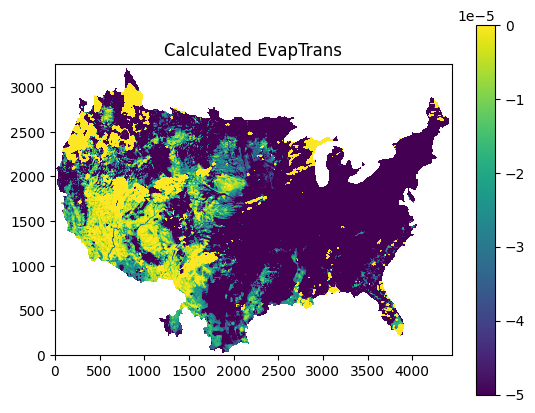

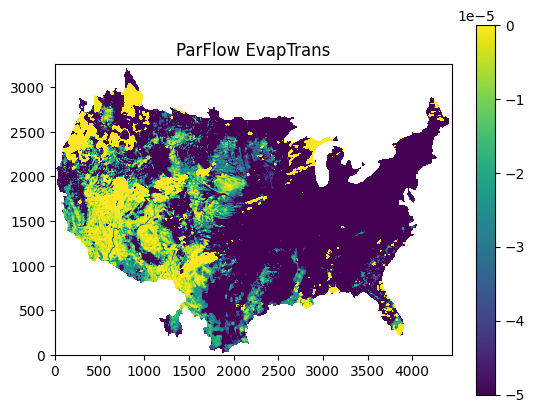

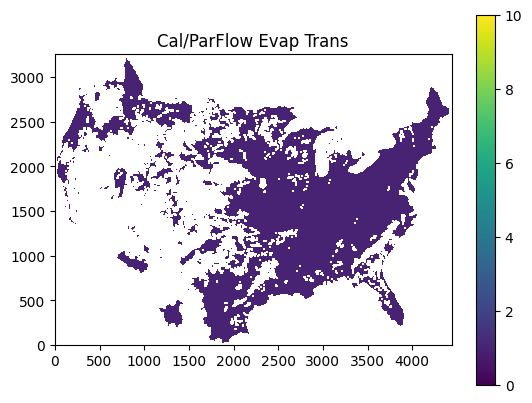

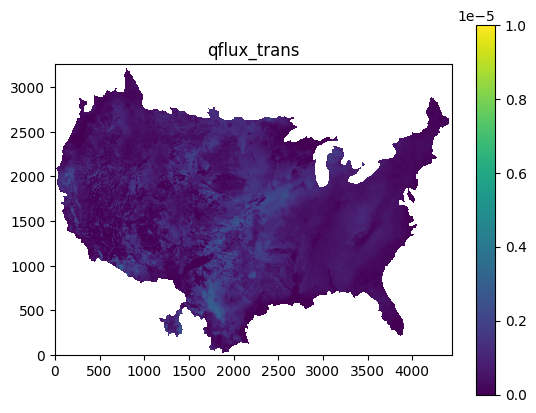

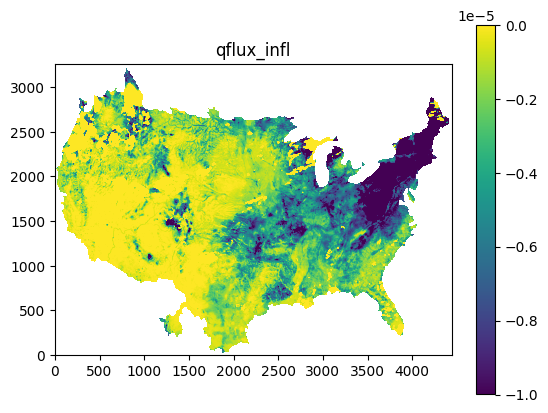

In [23]:
# Read in the evaptrans from the netcdf
fin= os.path.join(working_dir, '24h_test.out.00001.nc')
pf_output = nc.Dataset(fin)
#print(pf_output.variables)
pf_evaptrans = pf_output.variables['evaptrans']
print(pf_evaptrans.shape)

#pf_evaptrans_t = pf_evaptrans[(htest-1),:,:]
print(pf_evaptrans_t.shape)

# Compare one layer and plot: 
lay_test = 0 # Layer from the top moving down starting couting at 0
slice_testC = evap_trans[lay_test,:,:]
slice_testP = pf_evaptrans[(htest-1),(9-lay_test),:,:]
print('Calc ET: ', np.mean(slice_testC[mask==1]))
print('PF   ET: ', np.mean(slice_testP[mask==1])) 


## mapping
slice_testC[mask==0]= np.nan
str= plt.imshow(slice_testC, cmap = "viridis", origin='lower')
str.set_clim(vmin=(-5*1e-5), vmax=0)
plt.colorbar(str, ax=plt.gca())
plt.title('Calculated EvapTrans')
plt.show()

slice_testP[mask==0]=np.nan
str= plt.imshow(slice_testP, cmap = "viridis", origin='lower')
str.set_clim(vmin=(-5*1e-5), vmax=0)
plt.colorbar(str, ax=plt.gca())
plt.title('ParFlow EvapTrans')
plt.show()

ratio= slice_testC/slice_testP
ratio[mask==0]=np.nan
str= plt.imshow(ratio, cmap = "viridis", origin='lower')
str.set_clim(vmin=0, vmax=10)
plt.colorbar(str, ax=plt.gca())
plt.title('Cal/ParFlow Evap Trans')
plt.show()

tran_veg[mask==0]=np.nan
str= plt.imshow(tran_veg*mask, cmap = "viridis", origin='lower')
str.set_clim(vmin=0, vmax=1e-5)
plt.colorbar(str, ax=plt.gca())
plt.title('qflux_trans')
plt.show()

infl[mask==0]=np.nan
str= plt.imshow(infl*mask, cmap = "viridis", origin='lower')
str.set_clim(vmin=(-1*1e-5), vmax=0)
plt.colorbar(str, ax=plt.gca())
plt.title('qflux_infl')
plt.show()




## Check the evaptrans calculations
Looks like the issue is that the trans and infil numbers I have in the pfb outputs do not match George's net cdf. 

Transpiration numbers are close but the infiltration numbers are about twice as large in the netcdf files as in the pfb

I also checked below printing out the sum for all layers that the currect values where just at a different index value that I missed. 

And I checed that they aren't one time step off. 

It looks like I am grabbing the right layers and the right timesteps the values are just off between the pfbs and the netcdf

In [5]:
#Check that the transpiration and infiltration numbers match
fin= os.path.join(working_dir, '24h_test.out.CLM.00001.nc')
clm_output = nc.Dataset(fin)
#print(clm_output.variables)

qtrans = clm_output.variables['qflx_tran_veg']
qinf = clm_output.variables['qflx_infl']

print(qtrans.shape)
print(qinf.shape)

print("total transpiration:", np.sum(qtrans[(htest-1),:,:][mask==1]))
print("total infiltration:", np.sum(qinf[(htest-1),:,:][mask==1]))

# Read the C.pfb and see if I have any numbers that match
wy_hour = htest
fin1 = f"/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/run_inputs/spinup.wy{wy}.out.clm_output.{wy_hour:05d}.C.pfb"
testP = read_pfb(fin1)
print(testP.shape)
for i in range(17):
    print(i)
    print(np.sum(testP[i,:,:][mask==1]))
          

(24, 3256, 4442)
(24, 3256, 4442)
total transpiration: 21.610400803672363
total infiltration: 112.65367692923013
(17, 3256, 4442)
0
354748223.0379597
1
3190757665.550538
2
10329375.197188735
3
-625253159.7297215
4
141.31143365119507
5
96.24815957011077
6
96.24815957011077
7
45.06327408108421
8
25.848449855488116
9
61.64276455221861
10
0.0
11
2342562053.695361
12
0.0
13
2355846898.9261117
14
2355845852.1935477
15
2355562497.751936
16
2342562053.695361


(24, 10, 3256, 4442)
1
(10, 3256, 4442)
0.0002639227358213431
0.00023286025970209416


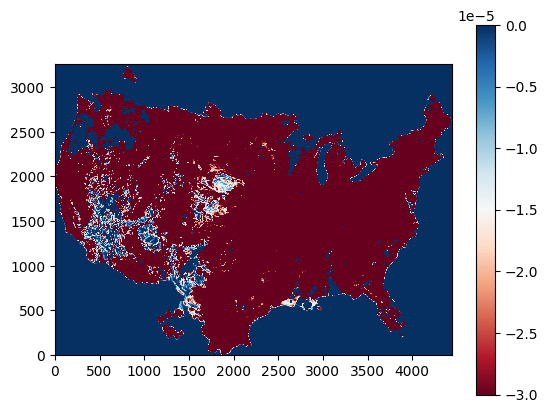

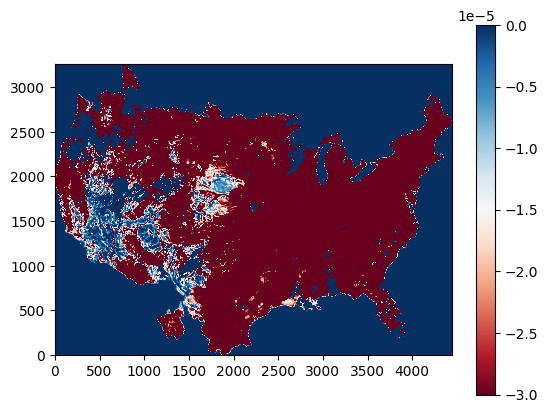

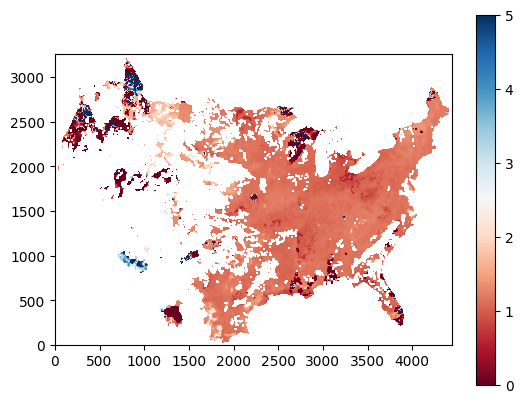

In [27]:
# Read in the PF nc file outputs
fin= os.path.join(working_dir, '24h_test.out.00001.nc')
pf_output = nc.Dataset(fin)
#print(pf_output.variables)
pf_evaptrans = pf_output.variables['evaptrans']
print(pf_evaptrans.shape)

#Read in the calculated evap trans for one test hour
print(htest)
#fin = os.path.join(working_dir, f'calculated_evaptrans.{htest:05d}.pfb')
#test_evaptrans = read_pfb(fin)
test_evaptrans = evap_trans # using the one just calculated instead of the pfb
print(test_evaptrans.shape)


l_test = 0 # Layer from the top moving down starting couting at 0
slice_testC = test_evaptrans[l_test,:,:]
slice_testP = pf_evaptrans[htest,(9-l_test),:,:]
print(np.mean(slice_testC))
print(np.mean(slice_testP)) 

#Test if I'm off by a constant factor
#print(np.mean(slice_testC/slice_test))
#print(np.mean(slice_testP)) 

str= plt.imshow(slice_testC, cmap = "RdBu", origin='lower')
str.set_clim(vmin=(-3*1e-5), vmax=0)
plt.colorbar(str, ax=plt.gca())
plt.show()

str= plt.imshow(slice_testP, cmap = "RdBu", origin='lower')
str.set_clim(vmin=(-3*1e-5), vmax=0)
plt.colorbar(str, ax=plt.gca())
plt.show()

str= plt.imshow(slice_testC/slice_testP, cmap = "RdBu", origin='lower')
str.set_clim(vmin=0, vmax=5)
plt.colorbar(str, ax=plt.gca())
plt.show()